# IGA Data Analysis
Daniel O'Nolan

In [1]:
#Import packages

from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import os, glob
import pathlib

#Data Digestion Functions

def IGA_Import(file):
    df_header = pd.read_csv(file,sep='= ',
                            nrows=33,
                            header=None,
                            engine='python')
    df = pd.read_csv(file,
                     delim_whitespace=True,
                     skiprows=35,
                     skipfooter=1,
                     header=None,
                     engine='python')
                            
    header = df_header[1].values.tolist()
    df.columns = header
    
    return(df)

def LogSplitter(df,ads_time=30, des_time=120,):
    Total_Run = df.where(df['Time (minute)'] < ads_time+des_time).dropna()
    Adsorption = Total_Run.where(Total_Run['Time (minute)'] < ads_time).dropna()
    Desorption = Total_Run.iloc[Adsorption.index[-1]+1:]
                            
    return(Total_Run.reset_index(),Adsorption.reset_index(), Desorption.reset_index())

#Data Transformation Functions

def CarbonCapture(Adsorption, Desorption):
    Adsorbed_Mass_Uptake = (
        (Adsorption['Total Weight (mg)'].max()-Adsorption['Total Weight (mg)'].min())/
        (Adsorption['Total Weight (mg)'].min())*100)
    
    p_H2O = 18.016*((Desorption['H2O (torr)']/Desorption['N2 (torr)']).sum())
    p_CO2 = 44.01*((Desorption['CO2 (torr)']/Desorption['N2 (torr)']).sum())
    CO2_Fraction = p_CO2/(p_H2O+p_CO2)
    CapturedCarbon = CO2_Fraction*Adsorbed_Mass_Uptake
                            
    return(Adsorbed_Mass_Uptake,CapturedCarbon, CO2_Fraction)

def RelativeHumidity(Adsorption):
    A,B,C = (8.07131,1730.63,233.426) # Antoine Equation Paramters
    T_VG1 = Adsorption['VG1 Temp (°C)']
    T_Sample = Adsorption['Sample Temp (°C)']
                            
    #Saturation Vapor Pressure of the Sample Chamber (torr)
    P_0 = 10**(       
        A-(B/(C+T_Sample))) 
    #Vapor Pressure Generated by the MFCs (torr)
    P = 10**(
        A-(B/(C+T_VG1)))*(Adsorption['Inlet A NITROGEN (ml/min)']/
                          (Adsorption['Inlet A NITROGEN (ml/min)']+
                           Adsorption['Inlet B NITROGEN (ml/min)']+
                           Adsorption['Inlet D NITROGEN (ml/min)'])) 
    RH = (P/P_0)*100
    meanRH = sum(RH) / len(RH)
    varianceRH = (sum([((x - meanRH) ** 2) for x in RH]) / len(RH))**0.5 
                            
    return(meanRH, varianceRH)

def MassSpecEval(Adsorption):
    H2O, CO2, N2 = Adsorption['H2O (torr)'], Adsorption['CO2 (torr)'], Adsorption['N2 (torr)']
    Water_Signal = H2O/N2
    CarbonDioxide_Signal = CO2/N2
    return(Water_Signal.max(), Water_Signal[0])

#Data Analytics

def IGA_Transform(file, ads_time=30, des_time=30+120):
    Raw_Data = IGA_Import(file)
    print(file)
    
    Data, Adsorption, Desorption = LogSplitter(Raw_Data, ads_time, des_time)
    
    Water_MS, Water_MS0 = MassSpecEval(Adsorption)
    print('max. water conc. in Mass Spec: ',Water_MS)
    print('min. water conc. in Mass Spec: ',Water_MS0)
    
    RH, SD = RelativeHumidity(Adsorption)
    print('Relative Humidity: ',RH,'%(+/-',SD,')')
    
    Adsorbed_Mass_Uptake, CapturedCarbon, CO2_Fraction = CarbonCapture(Adsorption, Desorption)
    print('Total Mass Uptake: ', Adsorbed_Mass_Uptake, ' wt.%')
    print('CO2 Fraction: ', CO2_Fraction)
    print('Carbon Captured: ', CapturedCarbon, 'wt.% CO2')
    
    Processed_Uptake = ((Adsorption['Total Weight (mg)']/Adsorption['Total Weight (mg)'].min())-1)*100
    Processed_DataFrame = pd.concat([Adsorption['Time (minute)'],Processed_Uptake],axis=1)
    Processed_DataFrame.columns = ['Time_'+str(ads_time), 'Uptake_'+str(ads_time)]
    
    print('\n')
    return(Processed_DataFrame, CapturedCarbon)

def Batch_IGA_Transform(path, 
                        time=[60,120,30,240,480],
                        info_labels='None',
                        User='Dan', 
                        Comment='PDendrimer_75%RH_400ppmCO2_AdsorptionProfiles_293K',
                        Verbose=True
                       ):
    Today = datetime.today().strftime('%Y%m%d')
    All_Data = pd.DataFrame()
    CO2 = []
    file = glob.glob(path+'*txt')
    for i,j in zip(file, time):
        a,b = IGA_Transform(i,j, j+120)
        All_Data = pd.concat([All_Data,a],axis=1)
        CO2.append(b)
        
    f = plt.figure(facecolor='w')
    f.set_size_inches(3.33, 3.33, forward=True)
    gs0 = gridspec.GridSpec(1, 1, figure=f)
    G00 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=1,subplot_spec=gs0[0],wspace=0.44, hspace=0)
    ax01 = plt.subplot(G00[0,0])
    
    colorwheel = cm.get_cmap('plasma')
    
    ax01.plot(time,CO2,marker='o',ms=8,mec='k',mfc='k',ls='none',label='CO$_{2}$ Uptake')
    ax01.set_ylabel('Uptake / wt. %')
    ax01.set_xlabel('Time / minutes')
    
    for i,j,k in zip(sorted(time,reverse=True),
                     np.linspace(0.1,0.8,len(time)), 
                     info_labels):
        ax01.plot(All_Data['Time_'+str(i)].dropna().iloc[::600], 
                  All_Data['Uptake_'+str(i)].dropna().iloc[::600],
                  marker='o',
                  ms=8,mec='k',
                  mfc=colorwheel(j),
                  ls='none')
        
        df = pd.DataFrame(pd.concat(
            [All_Data['Time_'+str(i)],
             All_Data['Uptake_'+str(i)]],
            axis=1)
                         ).dropna().T.to_json(
            Today+'_'+User+'_'+Comment+'_'+str(i)+'.json',orient='split')
    
    if info_labels != 'None':
        if Verbose==True:
            for i,j,k in zip(sorted(time,reverse=True),
                             np.linspace(0.1,0.8,len(time)), 
                             info_labels):
                label = ax01.annotate(k,
                                      (All_Data['Time_'+str(i)].dropna().iloc[-1],
                                       All_Data['Uptake_'+str(i)].dropna().iloc[-1]),
                                      xytext=(12, 0),
                                      textcoords='offset points',
                                      ha='left',
                                      va='center'
                                     )

            for i, txt in enumerate(CO2):   #### Listing Loop Problem!!!!
                ax01.annotate('CO$_{2} $'+f'{txt:.2f}'+' wt. %',
                              (time[i],CO2[i]),
                              xytext=(12, -5),
                              textcoords='offset points',
                              ha='left',
                              va='center'
                             )
                plt.draw()
                bbox = label.get_window_extent()
                ax01 = plt.gca()
                bbox_data = bbox.transformed(ax01.transData.inverted())
                ax01.update_datalim(bbox_data.corners())
                ax01.autoscale_view()

            else:
                pass
        else:
            pass
   
    plt.savefig(Today+'_'+User+'_'+Comment+'.svg', format='svg',facecolor=f.get_facecolor(), edgecolor='None',bbox_inches="tight")
    plt.savefig(Today+'_'+User+'_'+Comment+'.tiff', format='tiff',facecolor=f.get_facecolor(), edgecolor='None',bbox_inches="tight")
    plt.show(block='True')
    return('Batch Analysis Complete!')

C:\Users\donolan\PythonScripts\IGA\PDendrimer\PDendrimer_293K_16h\Data_PDendrimer_25%RH_400ppmCO2_293K_300sccm_16h-Adsorption.txt
max. water conc. in Mass Spec:  0.008609779482262703
min. water conc. in Mass Spec:  0.0015996112730806609
Relative Humidity:  25.002560293869095 %(+/- 0.3899017834125928 )
Total Mass Uptake:  6.957823800846659  wt.%
CO2 Fraction:  0.18776306109369212
Carbon Captured:  1.3064222953975162 wt.% CO2


C:\Users\donolan\PythonScripts\IGA\PDendrimer\PDendrimer_293K_16h\Data_PDendrimer_50%RH_400ppmCO2_293K_300sccm_16h-Adsorption.txt
max. water conc. in Mass Spec:  0.01853771402128644
min. water conc. in Mass Spec:  0.0021060320452403396
Relative Humidity:  49.99925122982277 %(+/- 0.4730872625742571 )
Total Mass Uptake:  17.173349053950357  wt.%
CO2 Fraction:  0.1786522065085413
Carbon Captured:  3.0680567016296014 wt.% CO2


C:\Users\donolan\PythonScripts\IGA\PDendrimer\PDendrimer_293K_16h\Data_PDendrimer_75%RH_400ppmCO2_293K_300sccm_16h-Adsorption.txt
max. water c

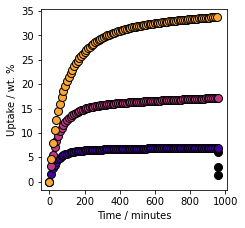

'Batch Analysis Complete!'

In [2]:
Batch_IGA_Transform(path=r'C:\Users\donolan\PythonScripts\IGA\PDendrimer\PDendrimer_293K_16h\\', 
                    time=[16*60+0.2,16*60+0.1,16*60+0.0],
                    info_labels = ['25%RH','50%RH','75%RH'],
                    User='Dan',
                    Verbose=False,
                    Comment='test')

In [26]:
def IGA_Import(file):
    df_header = pd.read_csv(file,sep='= ',nrows=33,header=None,engine='python')
    df = pd.read_csv(file,delim_whitespace=True,skiprows=35,skipfooter=1,header=None,engine='python')                        
    header = df_header[1].values.tolist()
    df.columns = header
    return(df)

def LogSplitter(df,ads_time=30, des_time=120,):
    Total_Run = df.where(df['Time (minute)'] < ads_time+des_time).dropna()
    Adsorption = Total_Run.where(Total_Run['Time (minute)'] < ads_time).dropna()
    Desorption = Total_Run.iloc[Adsorption.index[-1]+1:]                       
    return(Total_Run.reset_index(),Adsorption.reset_index(), Desorption.reset_index())


from scipy import integrate
def CO2Test(Desorption):
    A_H2O = sum(integrate.cumtrapz(Desorption['H2O (torr)'],Desorption['Time (minute)']))
    A_N2 = sum(integrate.cumtrapz(Desorption['N2 (torr)'],Desorption['Time (minute)']))
    A_CO2 = sum(integrate.cumtrapz(Desorption['CO2 (torr)'],Desorption['Time (minute)']))
    
    CO2_fraction = A_CO2 / A_N2
    H2O_fraction = A_H2O / A_N2
    print(CO2_fraction)
    print(H2O_fraction)
    total_flow = 300 * (Desorption['Time (minute)'].iloc[-1] - Desorption['Time (minute)'].iloc[0])
    print(total_flow)
    CO2_volume = CO2_fraction * total_flow
    H2O_volume = H2O_fraction * total_flow
    SampleMass = df['Total Weight (mg)'].iloc[0]/1000
    print("H2O volume ",H2O_volume)
    print("CO2 volume", CO2_volume)
    print("Sample Mass ", SampleMass, ' g')
    CO2_voluptake = CO2_volume
    CO2_moluptake = CO2_voluptake/22.414
    CO2_wtuptake = ((CO2_moluptake/1000)*44.01)/SampleMass
    print(CO2_wtuptake)
    H2O_moluptake = H2O_volume/22.414
    H2O_wtuptake = ((H2O_moluptake/1000)*44.01)/SampleMass
    print(H2O_wtuptake)
    return(CO2_wtuptake+H2O_wtuptake)




In [27]:
df = IGA_Import(r'C:\Users\donolan\PythonScripts\IGA\PDendrimer\PDendrimer_293K_16h\Data_PDendrimer_75%RH_400ppmCO2_293K_300sccm_16h-Adsorption.txt')
tr, ads, des = LogSplitter(df, ads_time=16*60)
x = CO2Test(des)
x

0.0005284297871821459
0.006782856951853144
35995.41899999997
H2O volume  244.15177799901656
CO2 volume 19.02105160170216
Sample Mass  0.13349860000000002  g
0.27976270175996476
3.5909981468317733


3.870760848591738

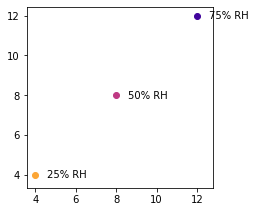

In [36]:
f = plt.figure(facecolor='w')
f.set_size_inches(3.33, 3.33, forward=True)
gs0 = gridspec.GridSpec(1, 1, figure=f)
G00 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=1,subplot_spec=gs0[0],wspace=0.44, hspace=0)
ax = plt.subplot(G00[0,0])

time = [8,4,12]
info_labels=['75% RH','50% RH','25% RH']
colorwheel = cm.get_cmap('plasma')
info_labels=['75% RH','50% RH','25% RH']

for i,j,k in zip(sorted(time,reverse=True),
                 np.linspace(0.1,0.8,len(time)), 
                 info_labels):
    ax.plot(i,i,'o',c=colorwheel(j))
    
    
    label = plt.annotate(k, (i,i),xytext=(12, 0),
                         textcoords='offset points',
                         ha='left', va='center')
    plt.draw()
    bbox = label.get_window_extent()
    ax = plt.gca()
    bbox_data = bbox.transformed(ax.transData.inverted())
    ax.update_datalim(bbox_data.corners())
    ax.autoscale_view()